<a href="https://colab.research.google.com/github/RobyRoshna/Insensitive-Lang-Detection/blob/Training/BERTOrginal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and custom



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from huggingface_hub import login
import wandb
from transformers import Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification, set_seed
import pandas as pd
import random
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import pickle

!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.1 MB/s eta 0:00:00


In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [ ]:
#Note: random_state for splits need to set separately for this study its 42 throughout
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
set_seed(42)

In [ ]:
# Custom Dataset Class for Tokenization
class SentenceDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels): #labels: List of labels corresponding to the sentences (e.g., 0 for NotInsensitive, 1 for Insensitive).

        self.encodings = encodings
        self.labels = labels

    def __len__(self):

        return len(self.labels)

    def __getitem__(self, idx):
        #For pytorch tensors
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Function to compute metrics
def compute_metrics(pred):
    predictions, labels = pred
    preds = predictions.argmax(axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Dataset Prep

In [ ]:
import pandas as pd

# File paths
file1 = "/content/drive/MyDrive/Honours MiscData(Roshna)/25Augmented_annotationsV2.csv"
file2 = "/content/drive/MyDrive/Honours MiscData(Roshna)/test_dataOriginal.csv"

# Load CSV files
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Ensure the 'Sentence' column exists in both files
if 'Sentence' not in df1.columns or 'Sentence' not in df2.columns:
    raise ValueError("One of the files does not contain a 'Sentence' column.")

# Convert 'Sentence' columns to strings for consistency
df1['Sentence'] = df1['Sentence'].astype(str)
df2['Sentence'] = df2['Sentence'].astype(str)

# Create a dictionary mapping sentences to their actual index in File2 (df2)
sentence_to_index_file2 = df2.set_index('Sentence').index.to_series().to_dict()

# Find matching sentences and store the actual 1-based indices
matching_records = []
for index1, sentence in df1['Sentence'].items():  # index1 is zero-based
    if sentence in sentence_to_index_file2:
        index2 = df2[df2['Sentence'] == sentence].index[0]  # Get the correct index from df2
        matching_records.append((index2 + 2, index1 + 2, sentence))  # Convert to 1-based row numbers

# Convert results to DataFrame
matching_df = pd.DataFrame(matching_records, columns=['File2 Row', 'File1 Row', 'Sentence'])

# Print total count of matches
print(f"Total Matching Sentences: {len(matching_df)}\n")

# Print the first few matches
print("Matching Records (File2 Row -> File1 Row -> Sentence):")
print(matching_df.head(20).to_string(index=False))  # Show first 20 matches neatly


Total Matching Sentences: 60

Matching Records (File2 Row -> File1 Row -> Sentence):
 File2 Row  File1 Row                                                                                                                                                                                                                                                                                                                                               Sentence
       103          3                                                                                                                                                                                         In our system, besides the user’s speech, the speech of individuals with the same type of disorder and even different types of disorders is also incorporated.
       108          6                                                                                                                                                            Children

In [ ]:

# The annotated dataset
file_path = '/content/drive/MyDrive/Honours MiscData(Roshna)/deduplicated_annotations.xlsx'
data = pd.read_excel(file_path)

# cleaning data
data = data[['Sentence', 'Manual_Annotation', 'Matched_Terms']]
data = data.dropna()

# 1 for insensitive and 0 for notInsensitive
data['Manual_Annotation'] = data['Manual_Annotation'].apply(lambda x: 1 if x.lower() == 'insensitive' else 0)

# Split the data into train, validation, and test sets
train_data, temp_data = train_test_split(data, test_size=0.2, stratify=data['Manual_Annotation'], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['Manual_Annotation'], random_state=42)

print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")
# Save train, val, and test splits
train_data.to_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/train_dataOriginal.csv", index=False)
val_data.to_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/val_dataOriginal.csv", index=False)
test_data.to_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/test_dataOriginal.csv", index=False)
print("Dataset splits saved!")


Train size: 867, Validation size: 108, Test size: 109
Dataset splits saved!


In [ ]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


def tokenize_data(data, tokenizer, max_length=109):
    return tokenizer(
        list(data['Sentence']),
        padding=True,
        truncation=True,
        max_length= max_length,
        return_tensors='pt'
    )

train_labels = list(train_data['Manual_Annotation'])
val_labels = list(val_data['Manual_Annotation'])
test_labels = list(test_data['Manual_Annotation'])

train_encodings = tokenize_data(train_data, tokenizer)
val_encodings = tokenize_data(val_data, tokenizer)
test_encodings = tokenize_data(test_data, tokenizer)



np.save("/content/drive/MyDrive/Honours MiscData(Roshna)/Original_train_encodings_input_ids.npy", train_encodings['input_ids'].numpy())
np.save("/content/drive/MyDrive/Honours MiscData(Roshna)/Original_train_encodings_attention_mask.npy", train_encodings['attention_mask'].numpy())
np.save("/content/drive/MyDrive/Honours MiscData(Roshna)/Original_train_labels.npy", np.array(train_labels))


In [ ]:

#datasets for train, validation, and test sets
train_datasetOriginalV2 = SentenceDataset(train_encodings, train_labels)
val_datasetOriginalV2 = SentenceDataset(val_encodings, val_labels)
test_datasetOriginalV2 = SentenceDataset(test_encodings, test_labels)


with open("/content/drive/MyDrive/Honours MiscData(Roshna)/train_datasetOriginalV2.pkl", "wb") as f:
    pickle.dump(train_datasetOriginalV2, f)
with open("/content/drive/MyDrive/Honours MiscData(Roshna)/val_datasetOriginalV2.pkl", "wb") as f:
    pickle.dump(val_datasetOriginalV2, f)
with open("/content/drive/MyDrive/Honours MiscData(Roshna)/test_datasetOriginalV2.pkl", "wb") as f:
    pickle.dump(test_datasetOriginalV2, f)


# Original BERT Model

In [ ]:

modelBbaseV2Original = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

wandb.finish()

wandb.init(project="Insensitive Lang Detecton", entity="Roshna", name="Bert_baseOrgininalV2")

# TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    logging_steps=10,
    report_to=["wandb"],  # WandB is used for logging
    run_name="Bert_base"  # the run name for this Trainer
)

# Trainer
trainer = Trainer(
    model=modelBbaseV2Original,
    args=training_args,
    train_dataset=train_datasetOriginalV2,
    eval_dataset=val_datasetOriginalV2,
    compute_metrics=compute_metrics,
)

trainer.train()

# Ensure to include training metrics at the end of training
train_results = trainer.predict(train_datasetOriginalV2)


predictions = train_results.predictions
labels = train_results.label_ids

# Compute metrics using the compute_metrics function
train_metrics = compute_metrics((predictions, labels))

wandb.log({f"train_{key}": value for key, value in train_metrics.items()})

# Output the metrics at the end of training needed for loos tredns
print("Training Metrics:")
for key, value in train_metrics.items():
    print(f"{key}: {value:.4f}")

# Compute evaluation metrics on the test set
test_results = trainer.evaluate(test_datasetOriginalV2, metric_key_prefix="test")
wandb.log(test_results)


wandb.finish()


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-15-1302a6248933>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.241200,0.169273,0.925926,0.952381,0.869565,0.909091
2,0.169700,0.122286,0.972222,0.977778,0.956522,0.967033
3,0.040500,0.119051,0.972222,0.977778,0.956522,0.967033


<ipython-input-15-1302a6248933>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-15-1302a6248933>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-15-1302a6248933>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-15-1302a6248933>:32: UserWarning: To copy construct fro

Training Metrics:
accuracy: 0.9942
precision: 0.9919
recall: 0.9946
f1: 0.9932


<ipython-input-15-1302a6248933>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


epoch,▁
eval/accuracy,▁██
eval/f1,▁██
eval/loss,█▁▁
eval/precision,▁██
eval/recall,▁██
eval/runtime,█▁▆
eval/samples_per_second,▁█▃
eval/steps_per_second,▁█▃
test/accuracy,█▁
test/f1,█▁


In [ ]:
save_directory = "/content/drive/MyDrive/Honours MiscData(Roshna)/Original_bert_base_model"


('/content/drive/MyDrive/Honours MiscData(Roshna)/Original_bert_base_model/tokenizer_config.json',
 '/content/drive/MyDrive/Honours MiscData(Roshna)/Original_bert_base_model/special_tokens_map.json',
 '/content/drive/MyDrive/Honours MiscData(Roshna)/Original_bert_base_model/vocab.txt',
 '/content/drive/MyDrive/Honours MiscData(Roshna)/Original_bert_base_model/added_tokens.json')

## Loss Trends

Train Metrics: {'accuracy': 0.99423, 'f1': 0.99323, 'precision': 0.99189, 'recall': 0.99458, 'loss': 0.0405, 'global_step': 165, 'grad_norm': 0.07208, 'learning_rate': 0.0, 'train_loss': 0.18936, 'runtime': 90.4431, 'samples_per_second': 28.758, 'steps_per_second': 1.824}
Validation Metrics: {'accuracy': 0.97222, 'f1': 0.96703, 'precision': 0.97778, 'recall': 0.95652, 'loss': 0.11905, 'runtime': 0.6407, 'samples_per_second': 168.572, 'steps_per_second': 10.926}
Test Metrics: {'accuracy': 0.92661, 'f1': 0.90698, 'precision': 0.975, 'recall': 0.84783, 'loss': 0.28281, 'runtime': 0.4874, 'samples_per_second': 223.643, 'steps_per_second': 14.362}


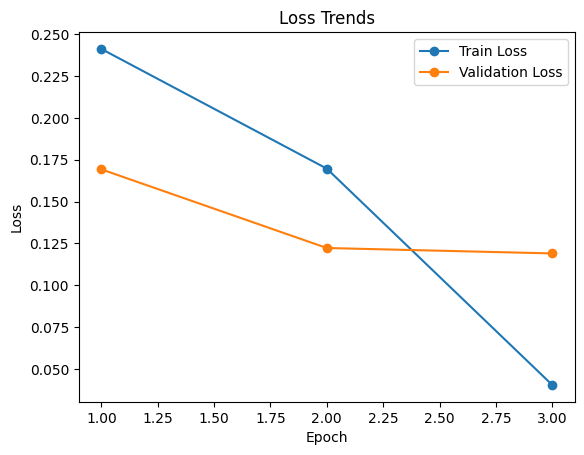

In [ ]:
import pandas as pd
import torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Compare Train, Validation, and Test Metrics reported during training above
val_metrics = {
    "accuracy": 0.97222,
    "f1": 0.96703,
    "precision": 0.97778,
    "recall": 0.95652,
    "loss": 0.11905,
    "runtime": 0.6407,
    "samples_per_second": 168.572,
    "steps_per_second": 10.926,
}
train_metrics = {
    "accuracy": 0.99423,
    "f1": 0.99323,
    "precision": 0.99189,
    "recall": 0.99458,
    "loss": 0.0405,
    "global_step": 165,
    "grad_norm": 0.07208,
    "learning_rate": 0.0,
    "train_loss": 0.18936,
    "runtime": 90.4431,
    "samples_per_second": 28.758,
    "steps_per_second": 1.824,
}
test_metrics = {
    "accuracy": 0.92661,
    "f1": 0.90698,
    "precision": 0.975,
    "recall": 0.84783,
    "loss": 0.28281,
    "runtime": 0.4874,
    "samples_per_second": 223.643,
    "steps_per_second": 14.362,
}

print("Train Metrics:", train_metrics)
print("Validation Metrics:", val_metrics)
print("Test Metrics:", test_metrics)

epochs = [1, 2, 3]
train_losses = [0.241200, 0.169700, 0.040500]
val_losses = [0.169273, 0.122286, 0.119051]

tl = plt.plot(epochs, train_losses, label="Train Loss", marker='o')
vl = plt.plot(epochs, val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Trends")
plt.legend()
plt.savefig("Originalloss_trends")
plt.show()



## Confusion Matrix

In [ ]:
import pandas as pd
import torch
import pickle
import wandb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertForSequenceClassification, BertTokenizer


test_data = pd.read_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/test_dataOriginal.csv")

model_path = "/content/drive/MyDrive/Honours MiscData(Roshna)/Original_bert_base_model"
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()


wandb.finish()
wandb.init(project="Insensitive Lang Detecton", entity="Roshna", name="Bert_baseOripred")

# Tokenize again
tokenizer = BertTokenizer.from_pretrained(model_path)
inputs = tokenizer(list(test_data['Sentence']), padding=True, truncation=True, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    confidences = torch.softmax(outputs.logits, dim=1)  # probabilities

test_predictions = outputs.logits.argmax(dim=1).cpu().numpy()
test_true_labels = test_data['Manual_Annotation'].values

wandb.finish()


conf_matrix = confusion_matrix(test_true_labels, test_predictions)

conf_matrix_df = pd.DataFrame(conf_matrix,
                              columns=["Predicted NotInsensitive", "Predicted Insensitive"],
                              index=["Actual NotInsensitive", "Actual Insensitive"])

print("Confusion Matrix - Test Set:")
print(conf_matrix_df)

# Analyze false positives and false negatives
false_positives = test_data[(test_true_labels == 0) & (test_predictions == 1)].copy()
false_negatives = test_data[(test_true_labels == 1) & (test_predictions == 0)].copy()

print("False Positives:")
print(false_positives[['Sentence', 'Manual_Annotation']])

print("\nFalse Negatives:")
print(false_negatives[['Sentence', 'Manual_Annotation']])


test_data = test_data.copy()
test_data['Confidence_Positive'] = confidences[:, 1].cpu().numpy()
test_data['Confidence_Negative'] = confidences[:, 0].cpu().numpy()

# Assign confidence values to misclassified examples
false_positives['Confidence_Positive'] = test_data.loc[false_positives.index, 'Confidence_Positive'].values
false_negatives['Confidence_Negative'] = test_data.loc[false_negatives.index, 'Confidence_Negative'].values

print("False Positives with Confidence:")
print(false_positives[['Sentence', 'Manual_Annotation', 'Confidence_Positive']])

print("\nFalse Negatives with Confidence:")
print(false_negatives[['Sentence', 'Manual_Annotation', 'Confidence_Negative']])


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: roshnaroby (Roshna) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Confusion Matrix - Test Set:
                       Predicted NotInsensitive  Predicted Insensitive
Actual NotInsensitive                        62                      1
Actual Insensitive                            7                     39
False Positives:
                                             Sentence  Manual_Annotation
46  Gaze typing for people with extreme motor disa...                  0

False Negatives:
                                              Sentence  Manual_Annotation
6    Our research contributes empirical evidence de...                  1
11   Story Blocks provides an introductory programm...                  1
27   Ongoing investigation of the ways in which som...                  1
62   The result demonstrated that only in the label...                  1
89   In this paper, we describe why designers need ...                  1
101  In our system, besides the user’s speech, the ...                  1
106  Children with autism spectrum disorder and oth...     

#EXP 1: Test augmented test set on model


Test Set Evaluation
Accuracy: 0.5953
Precision: 0.6252
Recall: 0.5942
F1 Score: 0.5681

Confusion Matrix - Test Set:
                       Predicted NotInsensitive  Predicted Insensitive
Actual NotInsensitive                        91                     17
Actual Insensitive                           70                     37

False Positives:
                                              Sentence  Label
4    "Many organizations now discourage the use of ...      0
8    "'Visually impaired' reflects a time when the ...      0
9    "The term 'able-bodied' is gradually being rep...      0
12   "Advocates suggest replacing 'illiterate' with...      0
38   "Our findings encourage reevaluating terms lik...      0
48   "The term 'hearing-impaired' appears in legacy...      0
51   "Our analysis shows that 'hearing-impaired' do...      0
70   "The guide was co-developed with experts from ...      0
84   "The term 'able-bodied' is addressed in this p...      0
90   "The conference on Special

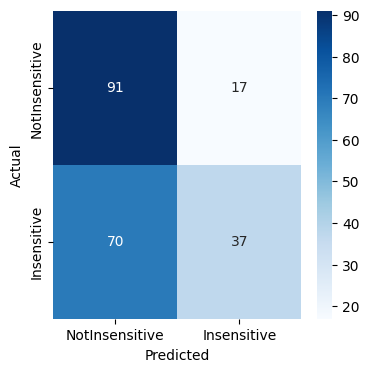

test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
test_accuracy,0.59535
test_f1,0.5681
test_precision,0.6252
test_recall,0.59419


In [ ]:
import pandas as pd
import torch
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


test_data = pd.read_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/AugTest_dataV2.csv")


model_path = "/content/drive/MyDrive/Honours MiscData(Roshna)/Original_bert_base_model"
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()
wandb.finish()
wandb.init(project="Insensitive Lang Detection", entity="Roshna", name="Bert_baseAugpred")


tokenizer = BertTokenizer.from_pretrained(model_path)
inputs = tokenizer(list(test_data['Sentence']), padding=True, truncation=True, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
    confidences = torch.softmax(outputs.logits, dim=1)
test_predictions = outputs.logits.argmax(dim=1).cpu().numpy()
test_true_labels = test_data['Label'].values
accuracy = accuracy_score(test_true_labels, test_predictions)
class_report = classification_report(test_true_labels, test_predictions, output_dict=True)
conf_matrix = confusion_matrix(test_true_labels, test_predictions)

# Extract Precision, Recall, and F1-score - macro average gives equal importance to both classes in binary classification
precision = class_report["macro avg"]["precision"]
recall = class_report["macro avg"]["recall"]
f1 = class_report["macro avg"]["f1-score"]
wandb.log({
    "test_accuracy": accuracy,
    "test_precision": precision,
    "test_recall": recall,
    "test_f1": f1
})

print("\nTest Set Evaluation")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix_df = pd.DataFrame(conf_matrix,
                              columns=["Predicted NotInsensitive", "Predicted Insensitive"],
                              index=["Actual NotInsensitive", "Actual Insensitive"])

print("\nConfusion Matrix - Test Set:")
print(conf_matrix_df)
wandb.log({"confusion_matrix": wandb.Table(dataframe=conf_matrix_df)})


false_positives = test_data[(test_true_labels == 0) & (test_predictions == 1)].copy()
false_negatives = test_data[(test_true_labels == 1) & (test_predictions == 0)].copy()
print("\nFalse Positives:")
print(false_positives[['Sentence', 'Label']])
print("\nFalse Negatives:")
print(false_negatives[['Sentence', 'Label']])
test_data['Confidence_Positive'] = confidences[:, 1].cpu().numpy()
test_data['Confidence_Negative'] = confidences[:, 0].cpu().numpy()
false_positives['Confidence_Positive'] = test_data.loc[false_positives.index, 'Confidence_Positive'].values
false_negatives['Confidence_Negative'] = test_data.loc[false_negatives.index, 'Confidence_Negative'].values

print("\nFalse Positives with Confidence:")
print(false_positives[['Sentence', 'Label', 'Confidence_Positive']])
print("\nFalse Negatives with Confidence:")
print(false_negatives[['Sentence', 'Label', 'Confidence_Negative']])
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["NotInsensitive", "Insensitive"],
            yticklabels=["NotInsensitive", "Insensitive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("AugTest_confusion_matrix")
plt.show()
wandb.finish()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: roshnaroby (Roshna) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



False negatives saved to false_negatives.csv


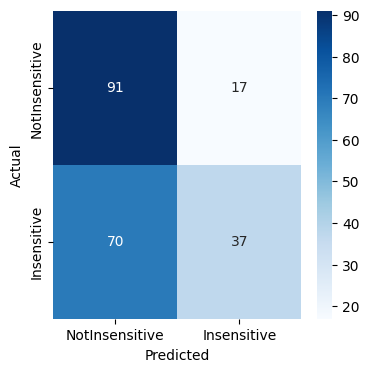

test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
test_accuracy,0.59535
test_f1,0.5681
test_precision,0.6252
test_recall,0.59419


In [ ]:
import pandas as pd
import torch
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load test data
test_data = pd.read_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/AugTest_dataV2.csv")

# Load model
model_path = "/content/drive/MyDrive/Honours MiscData(Roshna)/Original_bert_base_model"
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

# Initialize Weights & Biases
wandb.finish()
wandb.init(project="Insensitive Lang Detection", entity="Roshna", name="Bert_baseAugpred")

# Tokenize input sentences
tokenizer = BertTokenizer.from_pretrained(model_path)
inputs = tokenizer(list(test_data['Sentence']), padding=True, truncation=True, return_tensors="pt")

# Get model predictions
with torch.no_grad():
    outputs = model(**inputs)
    confidences = torch.softmax(outputs.logits, dim=1)

test_predictions = outputs.logits.argmax(dim=1).cpu().numpy()
test_true_labels = test_data['Label'].values

# Calculate accuracy metrics
accuracy = accuracy_score(test_true_labels, test_predictions)
class_report = classification_report(test_true_labels, test_predictions, output_dict=True)
conf_matrix = confusion_matrix(test_true_labels, test_predictions)

# Log to Weights & Biases
wandb.log({
    "test_accuracy": accuracy,
    "test_precision": class_report["macro avg"]["precision"],
    "test_recall": class_report["macro avg"]["recall"],
    "test_f1": class_report["macro avg"]["f1-score"]
})

# Extract false negatives (Actual: 1, Predicted: 0)
false_negatives = test_data[(test_true_labels == 1) & (test_predictions == 0)].copy()
test_data['Confidence_Positive'] = confidences[:, 1].cpu().numpy()
test_data['Confidence_Negative'] = confidences[:, 0].cpu().numpy()

# Add confidence scores to false negatives
false_negatives['Confidence_Negative'] = test_data.loc[false_negatives.index, 'Confidence_Negative'].values

# Save false negatives to CSV
false_negatives.to_csv("false_negatives.csv", index=False)
print("\nFalse negatives saved to false_negatives.csv")

# Plot confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["NotInsensitive", "Insensitive"],
            yticklabels=["NotInsensitive", "Insensitive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("AugTest_confusion_matrix")
plt.show()

wandb.finish()


# EXP 2: Test GPT test set on unaugmented model


Test Set Evaluation
Accuracy: 0.6279
Precision: 0.6706
Recall: 0.6267
F1 Score: 0.6019

Confusion Matrix - Test Set:
                       Predicted NotInsensitive  Predicted Insensitive
Actual NotInsensitive                        95                     13
Actual Insensitive                           67                     40

False Positives:
                                              Sentence  Label
3    "Advocates recommend replacing 'hearing-impair...      0
16   "The report traces the origins of the term 'si...      0
23   "Our research discusses how the label 'illiter...      0
46   "The app provides accessible features for user...      0
47   "The research focuses on mobility solutions fo...      0
65   "This toolset was developed to reduce barriers...      0
86   "Our research highlights the transition from u...      0
100  "The phrase 'sight-impaired' is mentioned in e...      0
128  "The program explores the intersections of tec...      0
158  "The study critiques the p

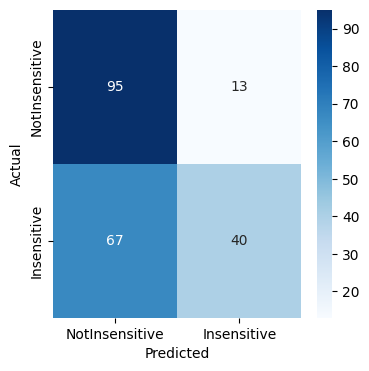

test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
test_accuracy,0.62791
test_f1,0.60185
test_precision,0.67057
test_recall,0.62673


In [ ]:
import pandas as pd
import torch
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load pure GPT test set
test_data = pd.read_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/ChatGPTtest_data.csv")

# Load the unaug model
model_path = "/content/drive/MyDrive/Honours MiscData(Roshna)/Original_bert_base_model"
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()


wandb.finish()
wandb.init(project="Insensitive Lang Detection", entity="Roshna", name="Bert_basegptpred")
tokenizer = BertTokenizer.from_pretrained(model_path)
inputs = tokenizer(list(test_data['Sentence']), padding=True, truncation=True, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    confidences = torch.softmax(outputs.logits, dim=1)

test_predictions = outputs.logits.argmax(dim=1).cpu().numpy()
test_true_labels = test_data['Label'].values

accuracy = accuracy_score(test_true_labels, test_predictions)
class_report = classification_report(test_true_labels, test_predictions, output_dict=True)
conf_matrix = confusion_matrix(test_true_labels, test_predictions)

# Extract Precision, Recall, and F1-score- macro average gives equal importance to both classes in binary classification
precision = class_report["macro avg"]["precision"]
recall = class_report["macro avg"]["recall"]
f1 = class_report["macro avg"]["f1-score"]

wandb.log({
    "test_accuracy": accuracy,
    "test_precision": precision,
    "test_recall": recall,
    "test_f1": f1
})


print("\nTest Set Evaluation")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


conf_matrix_df = pd.DataFrame(conf_matrix,
                              columns=["Predicted NotInsensitive", "Predicted Insensitive"],
                              index=["Actual NotInsensitive", "Actual Insensitive"])

print("\nConfusion Matrix - Test Set:")
print(conf_matrix_df)
wandb.log({"confusion_matrix": wandb.Table(dataframe=conf_matrix_df)})
false_positives = test_data[(test_true_labels == 0) & (test_predictions == 1)].copy()
false_negatives = test_data[(test_true_labels == 1) & (test_predictions == 0)].copy()

print("\nFalse Positives:")
print(false_positives[['Sentence', 'Label']])

print("\nFalse Negatives:")
print(false_negatives[['Sentence', 'Label']])
test_data['Confidence_Positive'] = confidences[:, 1].cpu().numpy()
test_data['Confidence_Negative'] = confidences[:, 0].cpu().numpy()
false_positives['Confidence_Positive'] = test_data.loc[false_positives.index, 'Confidence_Positive'].values
false_negatives['Confidence_Negative'] = test_data.loc[false_negatives.index, 'Confidence_Negative'].values
print("\nFalse Positives with Confidence:")
print(false_positives[['Sentence', 'Label', 'Confidence_Positive']])
print("\nFalse Negatives with Confidence:")
print(false_negatives[['Sentence', 'Label', 'Confidence_Negative']])


plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["NotInsensitive", "Insensitive"],
            yticklabels=["NotInsensitive", "Insensitive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.savefig("GPTtest_confusion_matrix")
plt.show()


wandb.finish()


# BERT Large

In [ ]:
train_path = "/content/drive/MyDrive/Honours MiscData(Roshna)/train_dataOriginal.csv"
val_path = "/content/drive/MyDrive/Honours MiscData(Roshna)/val_dataOriginal.csv"
test_path = "/content/drive/MyDrive/Honours MiscData(Roshna)/test_dataOriginal.csv"

# Load datasets
train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')


def tokenize_data(data, tokenizer, max_length=109):
    return tokenizer(
        list(data['Sentence']),
        padding=True,
        truncation=True,
        max_length= max_length,
        return_tensors='pt'
    )

train_labels = list(train_data['Manual_Annotation'])
val_labels = list(val_data['Manual_Annotation'])
test_labels = list(test_data['Manual_Annotation'])

train_encodings = tokenize_data(train_data, tokenizer)
val_encodings = tokenize_data(val_data, tokenizer)
test_encodings = tokenize_data(test_data, tokenizer)



np.save("/content/drive/MyDrive/Honours MiscData(Roshna)/Original_train_encodings_input_idsV2.npy", train_encodings['input_ids'].numpy())
np.save("/content/drive/MyDrive/Honours MiscData(Roshna)/Original_train_encodings_attention_maskV2.npy", train_encodings['attention_mask'].numpy())
np.save("/content/drive/MyDrive/Honours MiscData(Roshna)/Original_train_labels.npyV2", np.array(train_labels))


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [ ]:
modelLV2Original = BertForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="./results")
print(f"Default Learning Rate: {training_args.learning_rate}")


Default Learning Rate: 5e-05


In [ ]:
#datasets for train, validation, and test sets
train_datasetOriginalV2 = SentenceDataset(train_encodings, train_labels)
val_datasetOriginalV2 = SentenceDataset(val_encodings, val_labels)
test_datasetOriginalV2 = SentenceDataset(test_encodings, test_labels)

In [ ]:
import wandb
import numpy as np
from transformers import Trainer, TrainingArguments, BertForSequenceClassification, EvalPrediction

# Initialize WandB
wandb.finish()
wandb.init(project="Insensitive Lang Detection", entity="Roshna", name="Bert_Large_Original")

# Load BERT-Large model
model = BertForSequenceClassification.from_pretrained(
    "bert-large-uncased",
    num_labels=2
)

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results_bert_large",
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs_bert_large",
    report_to=["wandb"],  # Log with WandB
    run_name="Bert_Large_Original",
)

# Trainer Setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_datasetOriginalV2,
    eval_dataset=val_datasetOriginalV2,
    compute_metrics=compute_metrics,  # Using compute_metrics function
)

# Train the model
trainer.train()

# Compute training metrics after training
train_results = trainer.predict(train_datasetOriginalV2)
predictions = train_results.predictions
labels = train_results.label_ids

# Compute and log metrics using compute_metrics
train_metrics = compute_metrics((predictions, labels))
wandb.log({f"train_{key}": value for key, value in train_metrics.items()})

# Print final training metrics
print("\nTraining Metrics")
for key, value in train_metrics.items():
    print(f"{key}: {value:.4f}")

# Compute and log evaluation metrics on the test set
test_results = trainer.evaluate(test_datasetOriginalV2, metric_key_prefix="test")
wandb.log(test_results)

# Print test metrics
print("\nTest Set Evaluation")
for key, value in test_results.items():
    print(f"{key}: {value:.4f}")

wandb.finish()


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.57407


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-5-181cf056d201>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.231288,0.916667,0.951220,0.847826,0.896552
2,No log,0.157639,0.953704,0.955556,0.934783,0.945055
3,No log,0.179211,0.953704,0.955556,0.934783,0.945055


<ipython-input-5-181cf056d201>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-5-181cf056d201>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-5-181cf056d201>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-5-181cf056d201>:14: UserWarning: To copy construct from a 


Training Metrics
accuracy: 0.9792
precision: 0.9916
recall: 0.9593
f1: 0.9752


<ipython-input-5-181cf056d201>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}



Test Set Evaluation
test_loss: 0.2625
test_accuracy: 0.9174
test_precision: 1.0000
test_recall: 0.8043
test_f1: 0.8916
test_runtime: 1.6712
test_samples_per_second: 65.2240
test_steps_per_second: 2.3940
epoch: 3.0000


epoch,▁
eval/accuracy,▁██
eval/f1,▁██
eval/loss,█▁▃
eval/precision,▁██
eval/recall,▁██
eval/runtime,▃█▁
eval/samples_per_second,▆▁█
eval/steps_per_second,▆▁█
test/accuracy,█▁
test/f1,█▁


# Logisic Regression

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
train_df = pd.read_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/train_dataOriginal.csv")
val_df = pd.read_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/val_dataOriginal.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/test_dataOriginal.csv")

X_train = train_df['Sentence'].tolist()
y_train = train_df['Manual_Annotation'].tolist()

X_val = val_df['Sentence'].tolist()
y_val = val_df['Manual_Annotation'].tolist()

X_test = test_df['Sentence'].tolist()
y_test = test_df['Manual_Annotation'].tolist()

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

logistic_reg_model = LogisticRegression(max_iter=500, C=1.0)

# 5-Fold Cross-Validation**
cv_scores = cross_val_score(logistic_reg_model, X_train_tfidf, y_train, cv=5, scoring="accuracy")

print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", np.mean(cv_scores))


Cross-Validation Accuracy Scores: [0.89655172 0.93103448 0.89017341 0.89017341 0.87861272]
Mean Cross-Validation Accuracy: 0.8973091488937612


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Load datasets
train_df = pd.read_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/train_dataOriginal.csv")
val_df = pd.read_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/val_dataOriginal.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/test_dataOriginal.csv")

# Extract text and labels
X_train, y_train = train_df['Sentence'], train_df['Manual_Annotation']
X_val, y_val = val_df['Sentence'], val_df['Manual_Annotation']
X_test, y_test = test_df['Sentence'], test_df['Manual_Annotation']

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Train Logistic Regression Model
logistic_reg_model = LogisticRegression(max_iter=500, C=1.0)
logistic_reg_model.fit(X_train_tfidf, y_train)

def evaluate_model(model, X, y, dataset_name, dataset_df=None, show_conf_matrix=False):
    """Evaluates the model and prints precision, recall, F1-score, and accuracy."""

    predictions = model.predict(X)

    accuracy = accuracy_score(y, predictions)
    precision = precision_score(y, predictions)
    recall = recall_score(y, predictions)
    f1 = f1_score(y, predictions)

    # Print results
    print(f"\n{dataset_name} Set Evaluation")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix & Misclassified Examples (Only for test set)
    if show_conf_matrix and dataset_df is not None:
        conf_matrix = confusion_matrix(y, predictions)
        print("\nConfusion Matrix - Test Set:")
        print(pd.DataFrame(conf_matrix,
                           columns=["Predicted NotInsensitive", "Predicted Insensitive"],
                           index=["Actual NotInsensitive", "Actual Insensitive"]))

        # Convert Pandas Series to NumPy for proper filtering
        y_np = y.values
        misclassified_df = dataset_df[y_np != predictions]

        print("\nMisclassified Examples:")
        print(misclassified_df[['Sentence', 'Manual_Annotation']])

# Evaluate on Train, Validation, and Test sets
evaluate_model(logistic_reg_model, X_train_tfidf, y_train, "Train")
evaluate_model(logistic_reg_model, X_val_tfidf, y_val, "Validation")
evaluate_model(logistic_reg_model, X_test_tfidf, y_test, "Test", dataset_df=test_df, show_conf_matrix=True)



Train Set Evaluation
Accuracy: 0.9619
Precision: 0.9941
Recall: 0.9160
F1 Score: 0.9535

Validation Set Evaluation
Accuracy: 0.9259
Precision: 1.0000
Recall: 0.8261
F1 Score: 0.9048

Test Set Evaluation
Accuracy: 0.8899
Precision: 1.0000
Recall: 0.7391
F1 Score: 0.8500

Confusion Matrix - Test Set:
                       Predicted NotInsensitive  Predicted Insensitive
Actual NotInsensitive                        63                      0
Actual Insensitive                           12                     34

Misclassified Examples:
                                              Sentence  Manual_Annotation
6    Our research contributes empirical evidence de...                  1
7    In previous work we have presented a prototype...                  1
11   Story Blocks provides an introductory programm...                  1
23   We also report the results of an experiment th...                  1
27   Ongoing investigation of the ways in which som...                  1
36   The differen

In [ ]:
import joblib
model_filename = "/content/drive/MyDrive/Honours MiscData(Roshna)/Orilogistic_regression_model.pkl"
vectorizer_filename = "/content/drive/MyDrive/Honours MiscData(Roshna)/Oritfidf_vectorizer.pkl"

joblib.dump(logistic_reg_model, model_filename)
joblib.dump(vectorizer, vectorizer_filename)

['/content/drive/MyDrive/Honours MiscData(Roshna)/Oritfidf_vectorizer.pkl']

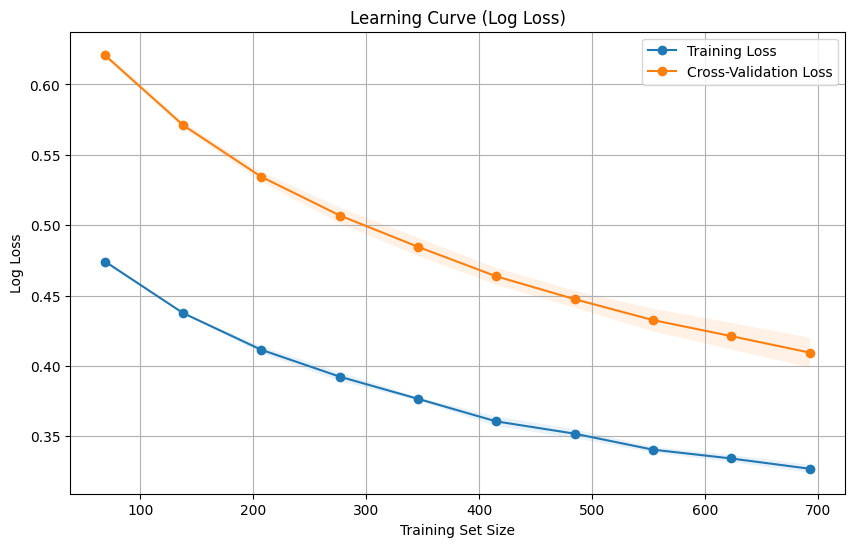

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(estimator, X, y, cv=5, scoring="neg_log_loss"):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    # Convert negative log loss back to positive
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label="Training Loss", marker='o')
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
    )
    plt.plot(train_sizes, test_scores_mean, label="Cross-Validation Loss", marker='o')
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
    )
    plt.title("Learning Curve (Log Loss)")
    plt.xlabel("Training Set Size")
    plt.ylabel("Log Loss")
    plt.legend(loc="best")
    plt.grid()

# Use log loss instead of accuracy
plot_learning_curve(
    logistic_reg_model,
    X_train_tfidf,
    y_train,
    cv=5,
    scoring="neg_log_loss"
)
plt.savefig("Logistic_learning_curve_log_loss.png")
plt.show()


In [ ]:
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# File Paths
model_filename = "/content/drive/MyDrive/Honours MiscData(Roshna)/Orilogistic_regression_model.pkl"
vectorizer_filename = "/content/drive/MyDrive/Honours MiscData(Roshna)/Oritfidf_vectorizer.pkl"
new_test_data_path = "/content/drive/MyDrive/Honours MiscData(Roshna)/AugTest_dataV2.csv"

# Load Saved Model & Vectorizer
logistic_reg_model = joblib.load(model_filename)
vectorizer = joblib.load(vectorizer_filename)

# Load New Test Dataset
new_test_df = pd.read_csv(new_test_data_path)

# Extract Sentences and Labels
X_new_test, y_new_test = new_test_df['Sentence'], new_test_df['Label']

# Transform Using the Same TF-IDF Vectorizer
X_new_test_tfidf = vectorizer.transform(X_new_test)

# Function to Evaluate Model & Print Correct Metrics
def evaluate_model(model, X, y, dataset_name, dataset_df=None, show_conf_matrix=False):
    """Evaluates the model and prints precision, recall, F1-score, and accuracy."""

    predictions = model.predict(X)

    # Compute Metrics
    accuracy = accuracy_score(y, predictions)
    precision = precision_score(y, predictions)
    recall = recall_score(y, predictions)
    f1 = f1_score(y, predictions)

    # Print Results
    print(f"\n{dataset_name} Set Evaluation")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix & Misclassified Examples
    if show_conf_matrix and dataset_df is not None:
        conf_matrix = confusion_matrix(y, predictions)
        print("\nConfusion Matrix:")
        print(pd.DataFrame(conf_matrix,
                           columns=["Predicted NotInsensitive", "Predicted Insensitive"],
                           index=["Actual NotInsensitive", "Actual Insensitive"]))

        # Get Misclassified Examples
        misclassified_df = dataset_df[y != predictions]

        print("\nMisclassified Examples:")
        print(misclassified_df[['Sentence', 'Label']])

# Evaluate the New Test Set
evaluate_model(logistic_reg_model, X_new_test_tfidf, y_new_test, "New Test", dataset_df=new_test_df, show_conf_matrix=True)



New Test Set Evaluation
Accuracy: 0.5814
Precision: 0.7931
Recall: 0.2150
F1 Score: 0.3382

Confusion Matrix:
                       Predicted NotInsensitive  Predicted Insensitive
Actual NotInsensitive                       102                      6
Actual Insensitive                           84                     23

Misclassified Examples:
                                              Sentence  Label
1    "The app includes features to address the spec...      1
2    Preliminary results of 5 healthy college stude...      1
5    "Our app provides visual schedules to support ...      1
8    "'Visually impaired' reflects a time when the ...      0
9    "The term 'able-bodied' is gradually being rep...      0
..                                                 ...    ...
200  "Programs for persons with disabilities should...      1
204  "Our findings show that chair-bound individual...      1
205  "The curriculum features simple topics for par...      1
206  "Wheelchair users reported

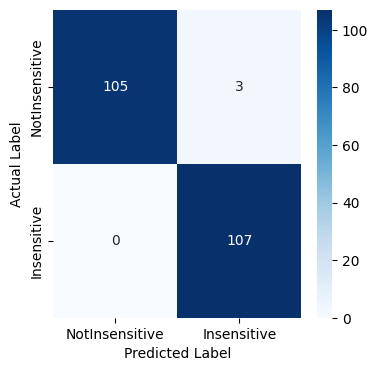

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the confusion matrix
conf_matrix = np.array([[105, 3],
                        [0, 107]])

# Define class labels
labels = ["Not Insensitive", "Insensitive"]

# Create the heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["NotInsensitive", "Insensitive"], yticklabels=["NotInsensitive", "Insensitive"])

# Add labels and title
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.savefig("Augmatrix.png")
# Show the plot
plt.show()
